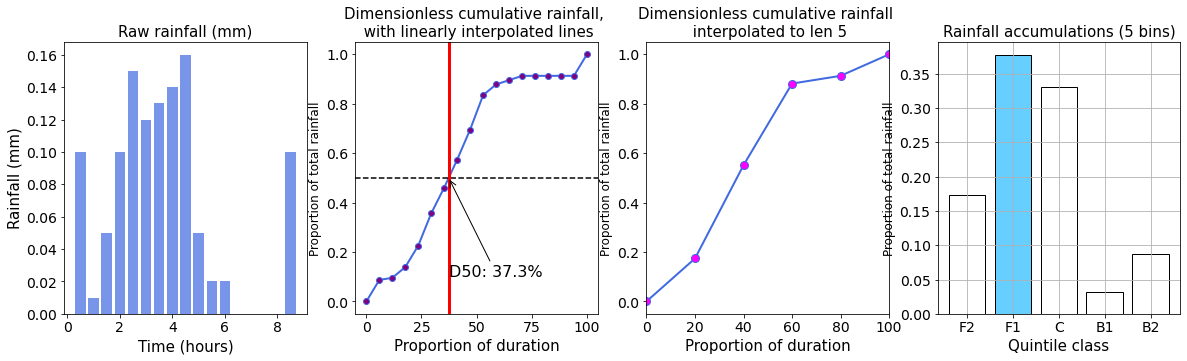

In [1]:
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

#### Function to find which fifth of the event contains the most rainfall
# First: Convert to dimensionless, cumulative rainfall event, and interpolate to length 5
def find_max_quintile (precip, n = 5):
    cumulative_rainfall, cumulative_rainfall_times = create_cumulative_event(precip)
    dimensionless_cumulative_rainfall, dimensionless_times =  create_dimensionless_event(cumulative_rainfall, cumulative_rainfall_times)
    interpolated_n_cumulative_rainfall, interpolated_n_times = interpolate_rainfall(dimensionless_cumulative_rainfall,n)
    interpolated_n_incremental_rainfall = create_incremental_event(interpolated_n_cumulative_rainfall)
    max_quintile_profile = find_part_with_most_rain(interpolated_n_incremental_rainfall, n)
    
    return max_quintile_profile 

#### Function convert a rainfall event to a dimensionless, cumulative version
def create_cumulative_event(rainfall, interval=0.5):
    
    # Calculate cumulative rainfall
    cumulative_rainfall = np.cumsum(rainfall)
    cumulative_rainfall = [0] + cumulative_rainfall
    
    # Generate corresponding time points
    time_points = np.arange(0, len(rainfall) + 1) * interval
    
    return  [0] + cumulative_rainfall.tolist(), time_points.tolist()

#### Function to convert a rainfall event to be dimensionless (both time and rainfall
# scaled to be between 0 and 1)
def create_dimensionless_event(cumulative_rainfall, cumulative_rainfall_times):
    # Normalize the cumulative rainfall by the total event depth
    total_event_depth = cumulative_rainfall[-1]
    normalized_cumulative_rainfall = np.array(cumulative_rainfall) / total_event_depth

    # Normalize the cumulative rainfall times by the total event time
    total_event_time = cumulative_rainfall_times[-1]
    normalized_cumulative_rainfall_times = np.array(cumulative_rainfall_times) / total_event_time
    
    return normalized_cumulative_rainfall, normalized_cumulative_rainfall_times

#### Function to interolate rainfall event
def interpolate_rainfall(rainfall, bin_number):
    if rainfall is None or len(rainfall) < 2:
        return None

    # Define target points for bin_number bins
    target_points = np.linspace(0, 1, bin_number+1)
    
    # Create interpolation function based on existing data points
    rainfall_times = np.array(range(0, len(rainfall)))

    # Normalize time from 0 to 1
    normalized_time = (rainfall_times - rainfall_times[0]) / (rainfall_times[-1] - rainfall_times[0])
    interpolation_func = interp1d(normalized_time, rainfall, kind='linear', fill_value="extrapolate")
    
    # Interpolate values at target points
    interpolated_values = interpolation_func(target_points)
    
    return interpolated_values, target_points

#### Function to create dimensionless, cumulative version of rainfall event (Huff curve)
def create_huff_curves(precip):
    cumulative_rainfall, cumulative_rainfall_times = create_cumulative_event(precip)
    dimensionless_cumulative_rainfall, dimensionless_times =  create_dimensionless_event(cumulative_rainfall, cumulative_rainfall_times)
    return dimensionless_cumulative_rainfall, dimensionless_times

#### Function to convert a cumulative rainfall curve, back to an incremental one
def create_incremental_event(cumulative_rainfall):
    if cumulative_rainfall is None :
        return None
    raw_rainfall = np.diff(cumulative_rainfall, prepend=0)
    return raw_rainfall[1:]

#### Function to find the fifth of a rainfall event which ontains the most rainfall,
#     and to plot with that fifth highlighted, if required
# NB if this is applied to an event with a number of points not divisible by n, then
# the results will be biased (as not all fifths will have the same number of data points)
def find_part_with_most_rain(array, n=5, plot=False, ax=False):

    # Compute differences
    # Split the array into 5 equal parts
    splits = np.array_split(array, n)

    max_array_rainfall = 0
    max_array_num = None

    total_precipitations = []  # To store total precipitation for each split
    split_ranges = []  # To store start and end indices for each split

    # Calculate total precipitation for each split
    split_start = 0
    for split in splits:
        total_precipitation = split.sum()
        total_precipitations.append(total_precipitation)
        split_end = split_start + len(split)
        split_ranges.append((split_start, split_end))
        if total_precipitation > max_array_rainfall:
            max_array_num = len(total_precipitations)
            max_array_rainfall = total_precipitation
        split_start = split_end

    colors = ['lightblue'] * n  # Default color for all splits
    highlight_color = 'yellow'  # Color for the split with the most rainfall

    if plot:
        # Plot the array
        ax.plot(range(1, len(array) + 1), array, label='Precipitation', marker='o')

        # Add vertical lines and shading for each split segment
        for i, (start_index, end_index) in enumerate(split_ranges):
            color = highlight_color if (i + 1) == max_array_num else colors[i]

            # Add vertical lines at the start and end of each split
            ax.axvline(x=start_index + 1, color=color, linestyle='--', label=f'Split {i+1} Start' if i == 0 or (i + 1) == max_array_num else "")
            ax.axvline(x=end_index, color=color, linestyle='--', label=f'Split {i+1} End' if i == 0 or (i + 1) == max_array_num else "")

            # Shade the region for the split
            ax.fill_between(range(start_index + 1, end_index + 1), array[start_index:end_index], color=color, alpha=0.3)

            # Add the total precipitation value behind the shading
            ax.text((start_index + end_index) / 2+0.5, max(array) * 0.05,  # Adjust y-position if needed
                    f'{total_precipitations[i]:.2f}',
                    ha='center', va='center', fontsize=10, color='black', weight='bold', zorder=1)

        ax.set_title(f'Precipitation Values with Splits Marked. Max at {max_array_num}')
        ax.set_xlabel('Time')
        ax.set_ylabel('Precipitation')

    return max_array_num   

## Function to plot 
def plot_incremental_rainfall(rainfall_array, ax, titles=True, labels=False):
    
    # Define custom labels for the bars
    bar_labels = ['F2', 'F1', 'C', 'B1', 'B2']

    # Define the color mapping
    color_mapping = {
        'F2': (0.0, 0.0, 1.0, 0.6),       # Blue with 0.6 transparency
        'F1': (0.0, 0.6902, 1.0, 0.6),    # Light blue with 0.6 transparency
        'C': (0.5, 0.5, 0.5, 0.6),        # Gray with 0.6 transparency
        'B1': (0.8039, 0.0, 0.0, 0.6),    # Red with 0.6 transparency
        'B2': (0.5451, 0.0, 0.0, 0.6)     # Dark red with 0.6 transparency
    }

    # Find the index of the maximum value
    index_of_max = np.argmax(rainfall_array)

    # Initialize all bars with a default color (e.g., white or light gray)
    colors = ['white'] * len(rainfall_array)  # Default color for all bars

    # Apply the color from the color_mapping to the bar at index_of_max
    colors[index_of_max] = color_mapping[bar_labels[index_of_max]]

    # Create the bar chart
    time_steps = np.arange(1, len(rainfall_array) + 1)
    ax.bar(time_steps, rainfall_array, label='Incremental Rainfall', color=colors, edgecolor='black')

    # Set custom labels on the x-axis
    ax.set_xticks(time_steps, bar_labels)
    
    ax.set_ylabel('Proportion of total rainfall', fontsize=12)
    if titles == True:
        ax.set_title('Rainfall accumulations (5 bins)', fontsize=15)
    if labels:
        ax.set_xlabel('Quintile class', fontsize=15)
    ax.grid('off');
    
def make_plot(sample, axs, titles=True, labels=True):
    n=5
    cumulative_rainfall, cumulative_rainfall_times = create_cumulative_event(sample)
    dimensionless_cumulative_rainfall, dimensionless_times = create_dimensionless_event(cumulative_rainfall, cumulative_rainfall_times)
    interpolated_n_cumulative_rainfall, interpolated_n_times = interpolate_rainfall(dimensionless_cumulative_rainfall, n)
    interpolated_n_incremental_rainfall = create_incremental_event(interpolated_n_cumulative_rainfall)
    max_quintile_profile = find_part_with_most_rain(interpolated_n_incremental_rainfall, n)
    x_ticks = np.array(range(1, len(sample) + 1)) * 0.5  # [0.5, 1.0, 1.5]
    
    # 1. Raw Data Plot
    axs[0].bar(np.array(range(1, len(sample) + 1)) * 0.5, sample, color='royalblue', alpha=0.7, width=0.4)

    axs[0].set_ylabel('Rainfall (mm)', fontsize=15)
    # axs[0].set_xticks(x_ticks)
    
    # 2. Dimensionless Cumulative Values
    time_percentage = (np.arange(0, len(sample) + 1) / len(sample)) * 100  
        
    axs[1].plot(time_percentage, dimensionless_cumulative_rainfall, 
                label='Cumulative Sum', linewidth=2, marker='o', color='royalblue', markerfacecolor='purple')

    # Plot horizontal line for the corresponding sample value
    percentile = 0.5
    total_duration = len(sample) * 0.5  # 1.5 hours
    axs[1].axhline(y=percentile, color='black', linestyle='--', label=f'{percentile}th Percentile')
    axs[2].set_ylabel('Proportion of total rainfall', fontsize=12)
    # Find intersection point for percentile line
    indices_below = np.where(dimensionless_cumulative_rainfall < percentile)[0]
    indices_above = np.where(dimensionless_cumulative_rainfall >= percentile)[0]
    
    if len(indices_below) > 0 and len(indices_above) > 0:
        index_below = indices_below[-1]
        index_above = indices_above[0]
        
        # Interpolation to find intersection
        x_below = time_percentage[index_below]
        y_below = dimensionless_cumulative_rainfall[index_below]
        x_above = time_percentage[index_above]
        y_above = dimensionless_cumulative_rainfall[index_above]
        slope = (y_above - y_below) / (x_above - x_below)
        time_for_percentile = x_below + (percentile - y_below) / slope
        
        axs[1].axvline(x=time_for_percentile, color='red', linestyle='-', linewidth=3)
        axs[1].annotate(f'D50: {time_for_percentile:.1f}%', 
                        xy=(time_for_percentile, percentile), 
                        xytext=(time_for_percentile, percentile  - 0.4),  
                        arrowprops=dict(facecolor='black', arrowstyle='->'),   
                        fontsize=16)

    # 3. Interpolated Cumulative Values
    interpolated_n_times_percentage = interpolated_n_times * 100 
    axs[2].plot(interpolated_n_times_percentage, interpolated_n_cumulative_rainfall, label='Cumulative Sum',linewidth=2,  marker='o', 
                color='royalblue', markersize=8, markerfacecolor='magenta')

    axs[2].set_ylabel('Proportion of total rainfall', fontsize=12)
    axs[2].set_xlim(0, 100)

    # Call the function for the last subplot
    plot_incremental_rainfall(interpolated_n_incremental_rainfall, axs[3], titles, labels)

    for ax in axs:
        ax.tick_params(axis='both', labelsize=14)  # Adjust labelsize as needed
     
    axs[1].set_ylabel('Proportion of total rainfall', fontsize=12)
    axs[2].set_ylabel('Proportion of total rainfall', fontsize=12)
    
    if labels == True:
        axs[0].set_xlabel('Time (hours)', fontsize=15) 
        axs[1].set_xlabel('Proportion of duration', fontsize=15)  
        axs[2].set_xlabel('Proportion of duration', fontsize=15)    
        
        
    if titles:
        axs[0].set_title('Raw rainfall (mm)', fontsize=15)        
        axs[2].set_title('Dimensionless cumulative rainfall \n interpolated to len 5', fontsize=15)        
        axs[1].set_title('Dimensionless cumulative rainfall, \n with linearly interpolated lines', fontsize=15)
        
        
### Example rainfall event
event = pd.DataFrame({'Precipitation (mm)':[0.1, 0.01, 0.05, 0.1, 0.15, 0.12, 0.13, 0.14, 0.16,0.05, 0.02, 0.02, 0,0,0,0,0.1]})

## Example of converting to dimesionless, cumulative version of event and plotting
fig,ax=plt.subplots(ncols=4, figsize=(20,5))
make_plot(event['Precipitation (mm)'], ax)

### Create dimensionless, cumulative versiono of event and plot
sample=event['Precipitation (mm)']
n=5
cumulative_rainfall, cumulative_rainfall_times = create_cumulative_event(sample)
dimensionless_cumulative_rainfall, dimensionless_times = create_dimensionless_event(cumulative_rainfall, cumulative_rainfall_times)
plt.plot(dimensionless_times, dimensionless_cumulative_rainfall, )

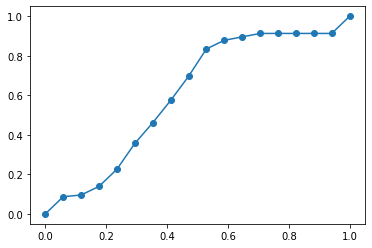

In [8]:
sample=event['Precipitation (mm)']
n=5
cumulative_rainfall, cumulative_rainfall_times = create_cumulative_event(sample)
dimensionless_cumulative_rainfall, dimensionless_times = create_dimensionless_event(cumulative_rainfall, cumulative_rainfall_times)
plt.plot(dimensionless_times, dimensionless_cumulative_rainfall, )
plt.scatter(dimensionless_times, dimensionless_cumulative_rainfall, )